In [177]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import qiskit

import numpy as np



In [178]:
# Define the ticker symbols and the date range
tickers = ['AAPL', 'TSLA', 'MSFT', 'GOOGL']
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)

# Download historical data for the last 2 years
data = yf.download(tickers, start=start_date, end=end_date)
data.head()

/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_55815/4275999229.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  4 of 4 completed


Price            Close                                           High  \
Ticker            AAPL      GOOGL        MSFT        TSLA        AAPL   
Date                                                                    
2020-09-24  105.267532  70.655678  194.823746  129.263336  107.242148   
2020-09-25  109.216759  71.460144  199.263123  135.779999  109.372397   
2020-09-28  111.823631  72.433418  200.816406  140.399994  112.173810   
2020-09-29  110.977371  72.798904  198.726181  139.690002  112.164088   
2020-09-30  112.650444  72.778038  201.669754  143.003326  114.060889   

Price                                                 Low             \
Ticker          GOOGL        MSFT        TSLA        AAPL      GOOGL   
Date                                                                   
2020-09-24  71.406996  197.105755  133.166672  102.135380  69.627271   
2020-09-25  71.801782  200.432876  136.243332  104.732529  69.901891   
2020-09-28  73.145010  203.817535  142.693329  109.703106  71.818663   
2020-09-29  73.095852  201.420493  142.833328  110.471561  72.202016   
2020-09-30  73.800981  203.251810  144.643326  110.520197  72.289411   

Price                                     Open                         \
Ticker            MSFT        TSLA        AAPL      GOOGL        MSFT   
Date                                                                    
2020-09-24  190.998027  117.099998  102.300740  69.653594  191.621272   
2020-09-25  194.200510  130.433334  105.471796  70.764442  195.168934   
2020-09-28  199.493222  138.516663  111.872270  73.095357  202.197117   
2020-09-29  198.294712  137.199997  111.424828  72.694128  200.730138   
2020-09-30  198.035797  140.156662  110.685557  72.546632  199.176802   

Price                      Volume                                 
Ticker            TSLA       AAPL     GOOGL      MSFT       TSLA  
Date                                                              
2020-09-24  121.266670  167743300  34552000  31202500  289683300  
2020-09-25  131.156662  149981400  30326000  29437300  201625500  
2020-09-28  141.539993  137672400  30784000  32004900  149158800  
2020-09-29  138.666672   99382200  31816000  24221900  150657900  
2020-09-30  140.440002  142675200  40924000  33829100  144436800

In [179]:
def add_sma(data: pd.DataFrame, ticker: str, window: int) -> pd.DataFrame:
    """Add Simple Moving Average (SMA) for a given ticker and window."""
    data[(f"SMA_{window}", ticker)] = (
        data["Close"][ticker].rolling(window=window).mean()
    )
    return data

def add_ema(data: pd.DataFrame, ticker: str, window: int) -> pd.DataFrame:
    """Add Exponential Moving Average (EMA) for a given ticker and window."""
    data[(f"EMA_{window}", ticker)] = (
        data["Close"][ticker].ewm(span=window, adjust=False).mean()
    )
    return data

def add_macd(data: pd.DataFrame, ticker: str, short=12, long=26, signal=9) -> pd.DataFrame:
    """Add MACD and Signal line for a given ticker."""
    ema_short = data["Close"][ticker].ewm(span=short, adjust=False).mean()
    ema_long = data["Close"][ticker].ewm(span=long, adjust=False).mean()
    
    data[("MACD", ticker)] = ema_short - ema_long
    data[("Signal_Line", ticker)] = data[("MACD", ticker)].ewm(span=signal, adjust=False).mean()
    return data

def add_rsi(data: pd.DataFrame, ticker: str, window: int = 14) -> pd.DataFrame:
    """Add Relative Strength Index (RSI) for a given ticker."""
    close = data["Close"][ticker]
    delta = close.diff()
    
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    data[(f"RSI_{window}", ticker)] = rsi
    return data

def add_atr(data: pd.DataFrame, ticker: str, window: int = 14) -> None:
    """Add Average True Range (ATR) for a given ticker."""
    high = data["High"][ticker]
    low = data["Low"][ticker]
    close = data["Close"][ticker]
    prev_close = close.shift(1)

    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    data[(f"ATR_{window}",ticker)] = tr.rolling(window=window).mean()


In [180]:
def add_all_indicators(data: pd.DataFrame, tickers: list) -> pd.DataFrame:
    for t in tickers:
        # Short/long SMAs
        data = add_sma(data, t, 20)
        data = add_sma(data, t, 50)
        # Short/long EMAs
        data = add_ema(data, t, 20)
        data = add_ema(data, t, 50)
        # MACD
        data = add_macd(data, t)
        # RSI
        data = add_rsi(data, t, 14)
        # ATR
        add_atr(data, t, 14)
    return data

In [181]:
data = add_all_indicators(data, tickers)

data[50:100].head()

Price            Close                                           High  \
Ticker            AAPL      GOOGL        MSFT        TSLA        AAPL   
Date                                                                    
2020-12-04  119.119896  90.563385  206.071915  199.679993  119.714278   
2020-12-07  120.581497  90.229179  206.004593  213.919998  121.380502   
2020-12-08  121.195374  89.946129  207.658096  216.626663  121.780017   
2020-12-09  118.661926  88.284103  203.610901  201.493332  122.725155   
2020-12-10  120.084579  87.777100  202.380417  209.023331  120.698454   

Price                                                 Low             ...  \
Ticker          GOOGL        MSFT        TSLA        AAPL      GOOGL  ...   
Date                                                                  ...   
2020-12-04  90.848414  207.052481  199.679993  118.408584  90.058361  ...   
2020-12-07  90.837979  207.206262  216.263336  119.119903  89.534470  ...   
2020-12-08  90.176542  208.561754  217.093338  119.938402  88.950501  ...   
2020-12-09  90.792309  206.908275  218.106674  117.901899  87.496536  ...   
2020-12-10  88.141583  204.841434  209.250000  117.073699  86.082784  ...   

Price          RSI_14    ATR_14     SMA_20     SMA_50     EMA_20     EMA_50  \
Ticker           MSFT      MSFT      GOOGL      GOOGL      GOOGL      GOOGL   
Date                                                                          
2020-12-04  46.127650  3.356581  87.783051  81.324427  87.179125  82.594314   
2020-12-07  44.011988  3.311151  87.925319  81.699808  87.469606  82.893720   
2020-12-08  55.620613  3.343384  88.049239  82.050062  87.705465  83.170285   
2020-12-09  51.785696  3.381835  88.148902  82.359766  87.760574  83.370827   
2020-12-10  45.273659  3.355741  88.199603  82.659747  87.762148  83.543622   

Price           MACD Signal_Line     RSI_14    ATR_14  
Ticker         GOOGL       GOOGL      GOOGL     GOOGL  
Date                                                   
2020-12-04  2.399467    2.437560  60.226384  1.692577  
2020-12-07  2.356702    2.421388  58.373534  1.668600  
2020-12-08  2.273760    2.391863  59.930334  1.697330  
2020-12-09  2.050282    2.323547  57.088450  1.838996  
2020-12-10  1.811383    2.221114  51.781672  1.877516  

[5 rows x 52 columns]

In [182]:
for ticker in tickers:
    data[('Change', ticker)] = data[('Close', ticker)] - data[('Open', ticker)]
    data[('Change %', ticker)] = 200*data[('Change', ticker)]/(data[('Close', ticker)] + data[('Open', ticker)])
data.head()

Price            Close                                           High  \
Ticker            AAPL      GOOGL        MSFT        TSLA        AAPL   
Date                                                                    
2020-09-24  105.267532  70.655678  194.823746  129.263336  107.242148   
2020-09-25  109.216759  71.460144  199.263123  135.779999  109.372397   
2020-09-28  111.823631  72.433418  200.816406  140.399994  112.173810   
2020-09-29  110.977371  72.798904  198.726181  139.690002  112.164088   
2020-09-30  112.650444  72.778038  201.669754  143.003326  114.060889   

Price                                                 Low             ...  \
Ticker          GOOGL        MSFT        TSLA        AAPL      GOOGL  ...   
Date                                                                  ...   
2020-09-24  71.406996  197.105755  133.166672  102.135380  69.627271  ...   
2020-09-25  71.801782  200.432876  136.243332  104.732529  69.901891  ...   
2020-09-28  73.145010  203.817535  142.693329  109.703106  71.818663  ...   
2020-09-29  73.095852  201.420493  142.833328  110.471561  72.202016  ...   
2020-09-30  73.800981  203.251810  144.643326  110.520197  72.289411  ...   

Price      RSI_14 ATR_14    Change  Change %    Change  Change %    Change  \
Ticker      GOOGL  GOOGL      AAPL      AAPL      TSLA      TSLA      MSFT   
Date                                                                         
2020-09-24    NaN    NaN  2.966793  2.858619  7.996666  6.383799  3.202473   
2020-09-25    NaN    NaN  3.744962  3.488740  4.623337  3.463995  4.094189   
2020-09-28    NaN    NaN -0.048639 -0.043487 -1.139999 -0.808682 -1.380711   
2020-09-29    NaN    NaN -0.447457 -0.402385  1.023331  0.735266 -2.003957   
2020-09-30    NaN    NaN  1.964887  1.759579  2.563324  1.808703  2.492952   

Price       Change %    Change  Change %  
Ticker          MSFT     GOOGL     GOOGL  
Date                                      
2020-09-24  1.657402  1.002084  1.428393  
2020-09-25  2.075992  0.695702  0.978315  
2020-09-28 -0.685193 -0.661938 -0.909701  
2020-09-29 -1.003342  0.104777  0.144030  
2020-09-30  1.243844  0.231406  0.318467  

[5 rows x 60 columns]

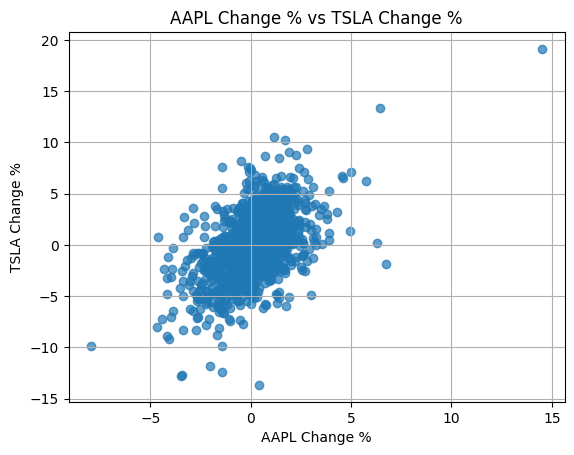

In [183]:
plt.scatter(data[('Change %', 'AAPL')], data[('Change %', 'TSLA')], alpha=0.7)
plt.xlabel('AAPL Change %')
plt.ylabel('TSLA Change %')
plt.title('AAPL Change % vs TSLA Change %')
plt.grid(True)
plt.show()

In [184]:

normalized_change = {}
for ticker in tickers:
    change_pct = data[('Change %', ticker)]
    norm = (change_pct - change_pct.min()) / (change_pct.max() - change_pct.min())
    normalized_change[ticker] = pd.Series(norm, index=data.index, name=ticker)
normalized_change


{'AAPL': Date
 2020-09-24    0.481320
 2020-09-25    0.509373
 2020-09-28    0.352119
 2020-09-29    0.336141
 2020-09-30    0.432391
                 ...   
 2025-09-17    0.354428
 2025-09-18    0.315112
 2025-09-19    0.432168
 2025-09-22    0.491397
 2025-09-23    0.328842
 Name: AAPL, Length: 1255, dtype: float64,
 'TSLA': Date
 2020-09-24    0.611450
 2020-09-25    0.522395
 2020-09-28    0.392077
 2020-09-29    0.439168
 2020-09-30    0.471908
                 ...   
 2025-09-17    0.490020
 2025-09-18    0.330043
 2025-09-19    0.447318
 2025-09-22    0.438595
 2025-09-23    0.316948
 Name: TSLA, Length: 1255, dtype: float64,
 'MSFT': Date
 2020-09-24    0.446290
 2020-09-25    0.474300
 2020-09-28    0.289539
 2020-09-29    0.268250
 2020-09-30    0.418617
                 ...   
 2025-09-17    0.327520
 2025-09-18    0.295499
 2025-09-19    0.431286
 2025-09-22    0.320576
 2025-09-23    0.275605
 Name: MSFT, Length: 1255, dtype: float64,
 'GOOGL': Date
 2020-09-24    0.54234

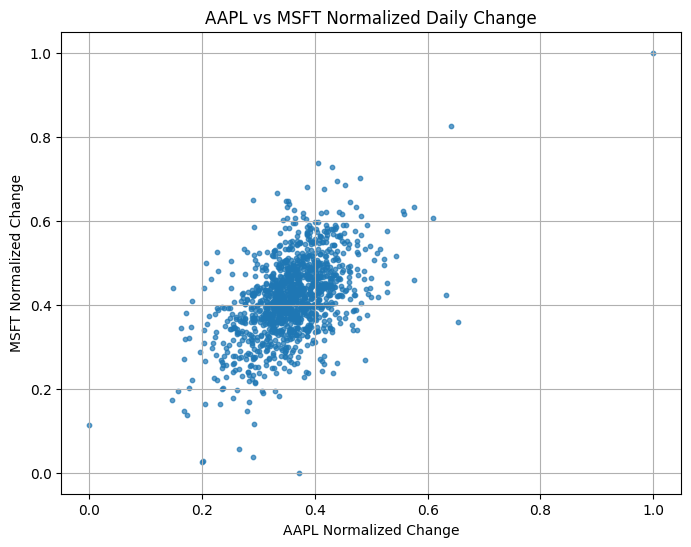

In [185]:
plt.figure(figsize=(8, 6))
plt.scatter(normalized_change['AAPL'], normalized_change['TSLA'], alpha=0.7, s=10)
plt.xlabel('AAPL Normalized Change')
plt.ylabel('MSFT Normalized Change')
plt.title('AAPL vs MSFT Normalized Daily Change')
plt.grid(True)
plt.show()

In [186]:
import qiskit
from qiskit.circuit.library import EfficientSU2

import numpy as np

In [187]:
num_stocks = len(tickers)
num_data_points = 12
num_qubits = num_stocks * int(np.ceil(num_data_points/4))

qc = qiskit.QuantumCircuit(num_qubits)



In [188]:
def data_loading_layer(qc, num_data_points, tickers):
    """
    Adds EfficientSU2 blocks to the quantum circuit for each ticker.
    
    Parameters:
        qc : QuantumCircuit
            The quantum circuit to append blocks to.
        num_data_points : int
            Number of data points (controls block size).
        tickers : list[str]
            List of ticker symbols (used as parameter prefixes).
    
    Returns:
        QuantumCircuit with appended EfficientSU2 blocks.
    """
    start = 0
    num_stocks = len(tickers)

    if num_data_points <= 2:
        group_sizes = num_stocks * [1]
    else:
        group_size = int(np.ceil(num_data_points / 4))
        group_sizes = num_stocks * [group_size]

    for ticker, size in zip(tickers, group_sizes):
        qubit_indices = list(range(start, start + size))
        su2_block = EfficientSU2(
            size,
            entanglement='circular',
            reps=1,
            insert_barriers=True,
            parameter_prefix=ticker  # prefix = ticker
        )
        qc.append(su2_block, qubit_indices)
        start += size

    return qc

In [189]:
data_loading_layer(qc,num_data_points,tickers)

/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_55815/1352235380.py:27: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  su2_block = EfficientSU2(


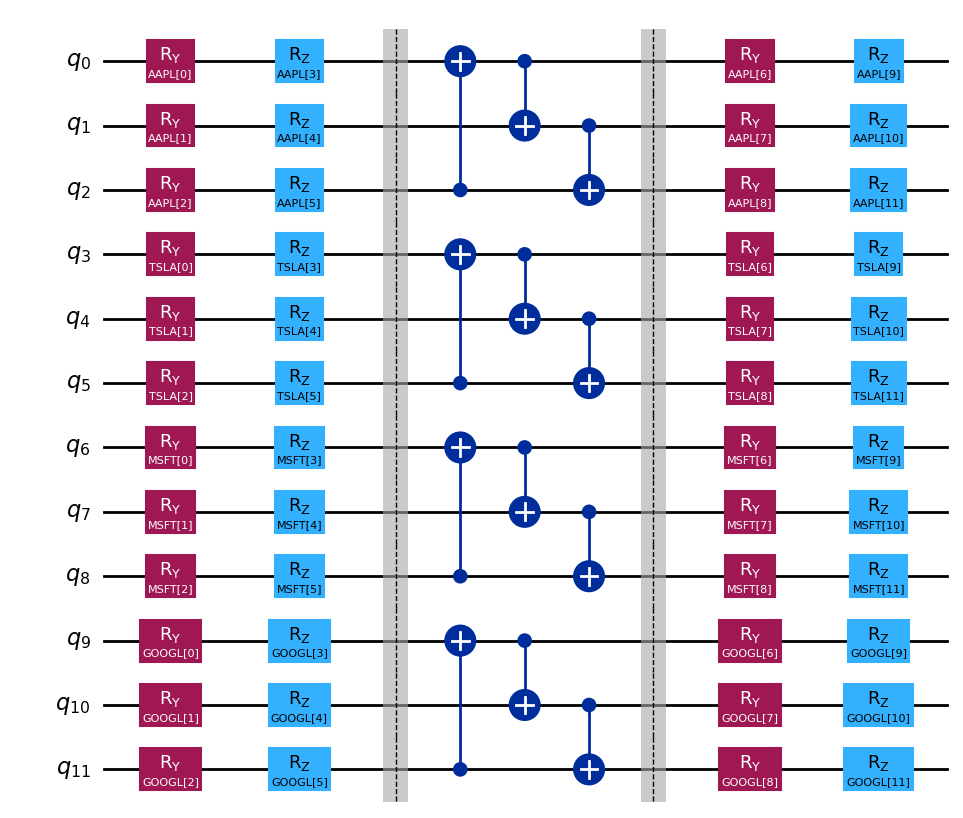

In [190]:

qc.decompose(reps=2).draw('mpl', fold=-1)

In [191]:
from qiskit.circuit.library import ZZFeatureMap

def parameterized_zz_layer(qc, num_data_points, tickers, reps=1):
    """
    Adds a ZZFeatureMap layer with reverse circular entanglement for multiple tickers.
    
    Each ticker is assigned a block of qubits. Within each block, reverse circular
    entanglement is applied, and the top qubit of one block is entangled with the 
    bottom qubit of the next block (circularly across tickers).
    
    Parameters:
        qc : QuantumCircuit
            The quantum circuit to append the layer to.
        num_data_points : int
            Number of data points (controls block size).
        tickers : list[str]
            List of ticker symbols (used as parameter prefixes).
        reps : int
            Number of repetitions of the ZZFeatureMap.
            
    Returns:
        QuantumCircuit with appended ZZFeatureMap layer.
    """
    start = 0
    num_stocks = len(tickers)

    # Determine qubit allocation per ticker
    if num_data_points <= 2:
        group_sizes = num_stocks * [1]
    else:
        group_size = int(np.ceil(num_data_points / 4))
        group_sizes = num_stocks * [group_size]

    block_indices = []
    for size in group_sizes:
        block_indices.append(list(range(start, start + size)))
        start += size

    # Apply ZZFeatureMap for each block
    for ticker, qubits in zip(tickers, block_indices):
        zz_block = ZZFeatureMap(
            feature_dimension=len(qubits),
            reps=reps,
            entanglement='reverse_linear',
            insert_barriers=True,
            parameter_prefix=f"{ticker}_zz"  # prefix = ticker
        )
        qc.compose(zz_block, qubits, inplace=True)

    # Connect top qubit of one block to bottom of next block (circular)
    for i in range(len(block_indices)):
        current_block = block_indices[i]
        next_block = block_indices[(i + 1) % num_stocks]
        qc.cz(current_block[-1], next_block[0])  # CZ between top and next bottom

    return qc

/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_55815/1423804949.py:41: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  zz_block = ZZFeatureMap(


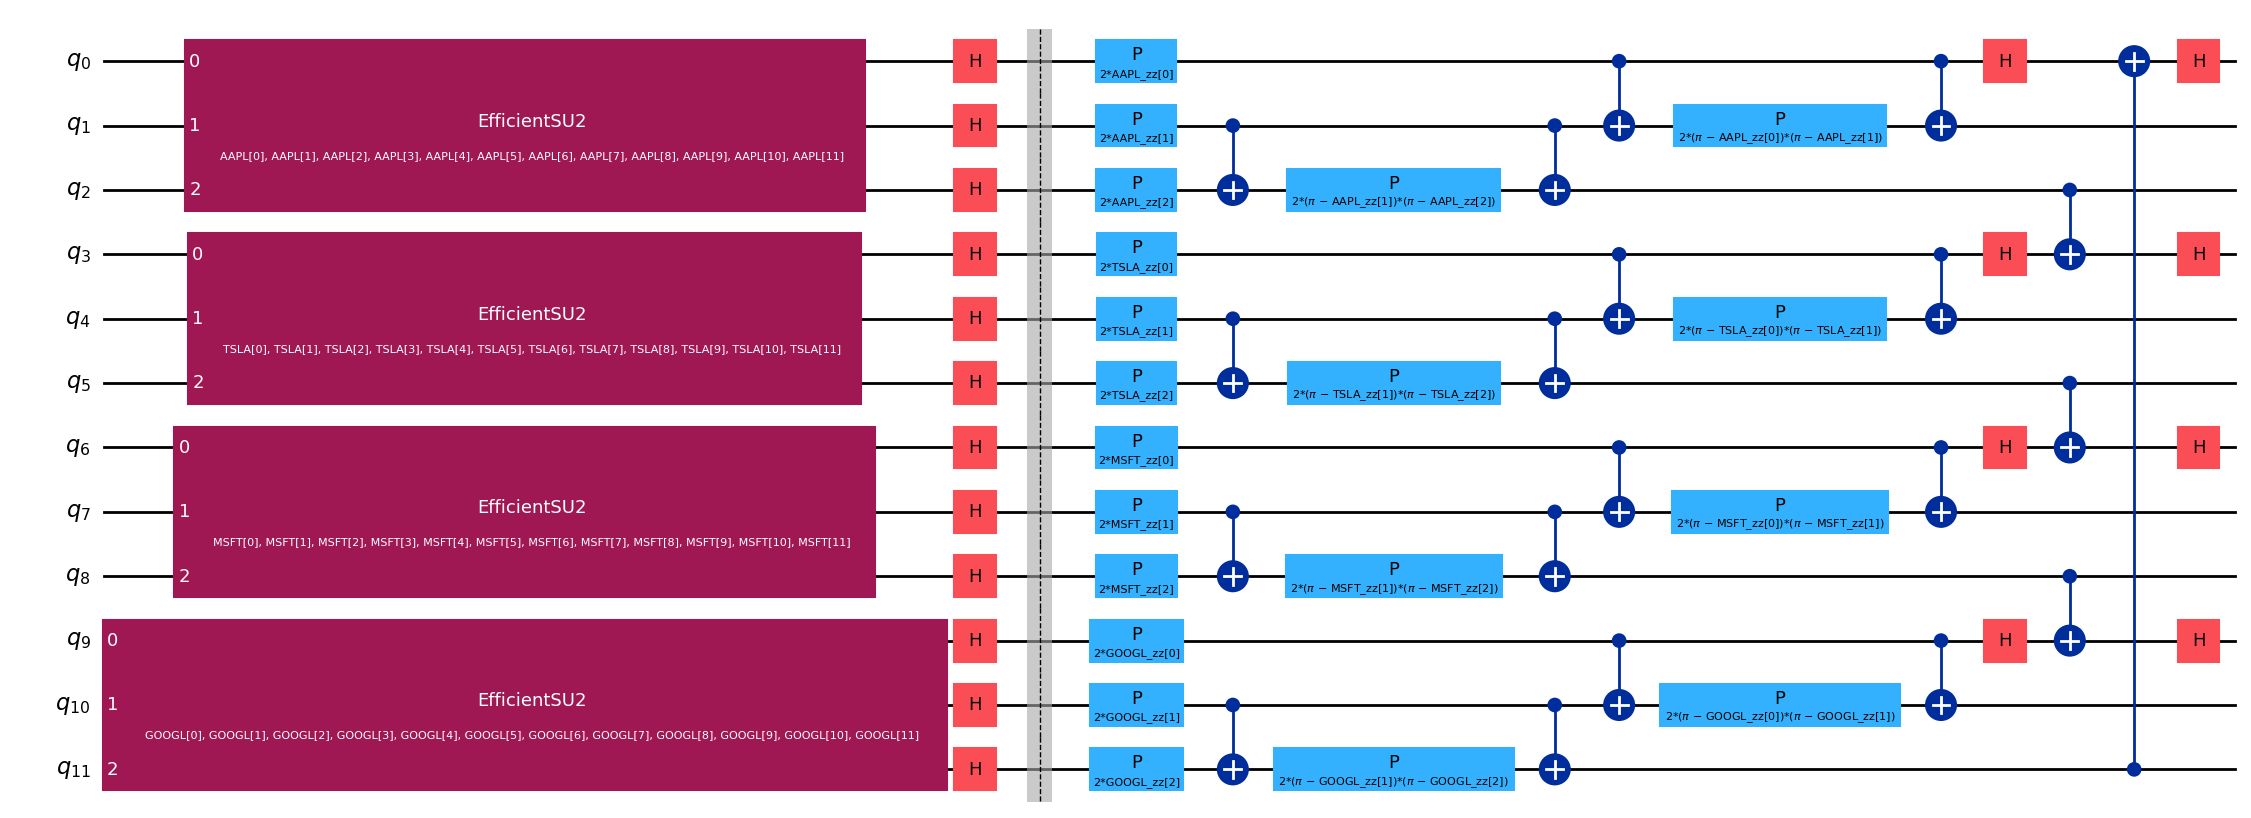

In [192]:
parameterized_zz_layer(qc, num_data_points, tickers, reps=1)

qc.decompose(reps=1).draw('mpl', fold=-1)


In [193]:
from qiskit import transpile, QuantumCircuit

def optimise_circuit_best(qc: QuantumCircuit, backend=None, trials: int = 5):
    """
    Transpile the quantum circuit multiple times and pick the one with the lowest 2-qubit depth.
    
    Parameters:
        qc : QuantumCircuit
            The quantum circuit to optimize.
        backend : Optional[BaseBackend]
            The backend to transpile for (None uses default simulator).
        trials : int
            Number of transpilation trials.
    
    Returns:
        best_qc : QuantumCircuit
            Transpiled circuit with lowest 2-qubit gate depth.
        best_2q_depth : int
            Depth of 2-qubit gates of the best circuit.
    """
    best_qc = None
    best_2q_depth = float('inf')

    for _ in range(trials):
        transpiled = transpile(qc, backend=backend, optimization_level=3)

        # Filter 2-qubit gates using a lambda
        two_qubit_gates = list(filter(lambda inst: inst[0].num_qubits == 2, transpiled.data))
        
        # Create a temporary circuit with only 2-qubit gates to compute depth
        temp_qc = QuantumCircuit(transpiled.num_qubits)
        for inst, qargs, cargs in two_qubit_gates:
            temp_qc.append(inst, qargs, cargs)
        
        two_q_depth = temp_qc.depth()

        print(f"Trial 2Q Depth: {two_q_depth}")
        if two_q_depth < best_2q_depth:
            best_2q_depth = two_q_depth
            best_qc = transpiled

    return best_qc, best_2q_depth

In [194]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)

print(f"{backend}")

<IBMBackend('ibm_torino')>


/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_55815/3720860525.py:28: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  two_qubit_gates = list(filter(lambda inst: inst[0].num_qubits == 2, transpiled.data))
/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_55815/3720860525.py:32: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in two_qubit_gates:


Trial 2Q Depth: 14
Trial 2Q Depth: 17
Trial 2Q Depth: 17
Trial 2Q Depth: 14
Trial 2Q Depth: 16
Trial 2Q Depth: 14
Trial 2Q Depth: 18
Trial 2Q Depth: 18
Trial 2Q Depth: 21
Trial 2Q Depth: 17
59
14


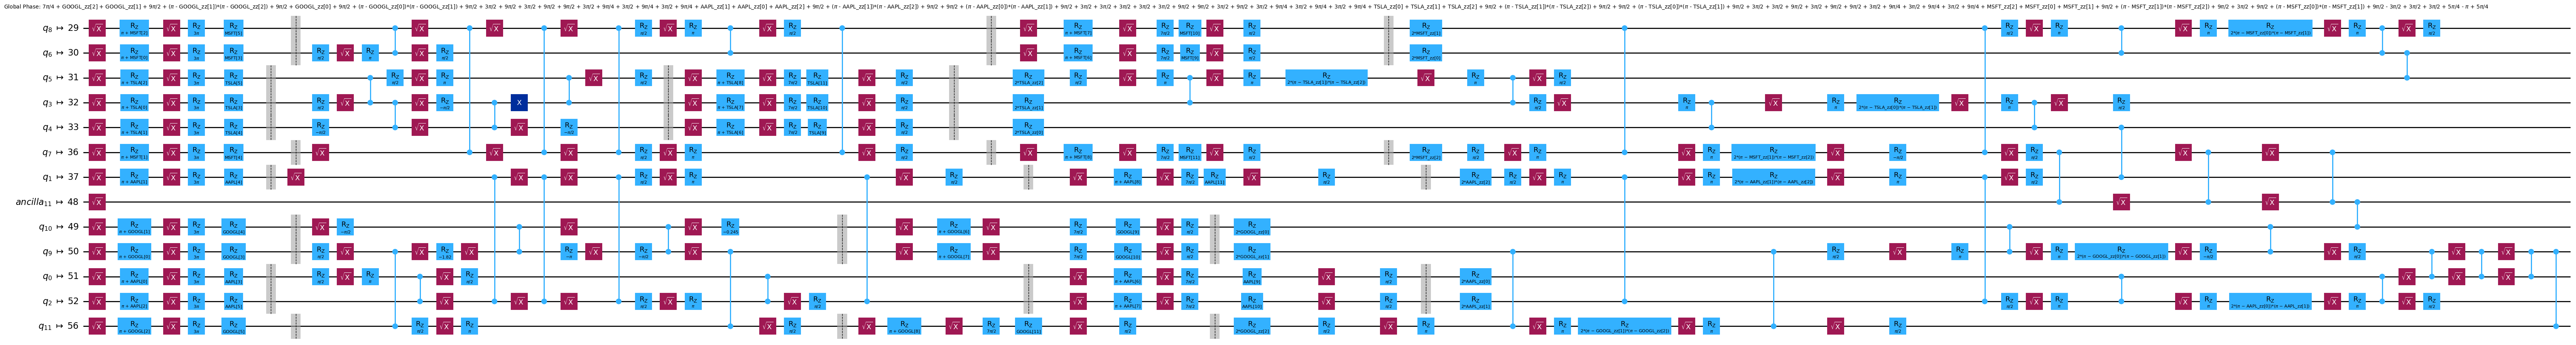

In [195]:

circuit , q_2 = optimise_circuit_best(qc, trials=10, backend=backend)
print(circuit.depth())
print(q_2)
circuit.draw('mpl', fold=-1)